In [3]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit, vmap, grad
from jax import scipy as jsc
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import chi2
import numpy as np

sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
def sort_by_square(x):
    sorted_indices = jnp.argsort(jnp.square(x))
    sorted_x = x[sorted_indices]
    return sorted_x


def pick_top_k_by_square(samples, k):
    # Sort samples based on their squared values in descending order
    sorted_indices = jnp.argsort(jnp.square(samples))[-k:]  # Get the top k based on x^2
    return samples[sorted_indices]


# Vectorize the function with vmap and apply jit for optimization
vmaped_pick_top_k_by_square = vmap(pick_top_k_by_square, in_axes=(0, None))


def pick_top_k_by_abs(samples, k):
    # Sort samples based on their squared values in descending order
    sorted_indices = jnp.argsort(jnp.abs(samples))[-k:]  # Get the top k based on x^2
    return samples[sorted_indices]


# Vectorize the function with vmap and apply jit for optimization
vmaped_pick_top_k_by_abs = vmap(pick_top_k_by_abs, in_axes=(0, None))


def simulate_minmax_order_statistic(m, s, key, k, batch_sz, useSquare=True):
    print("m : ", m)

    # Generate samples from a normal distribution
    samples = s * jax.random.normal(key, shape=(batch_sz, m))  # (size, m)

    # Apply vmaped_pick_top_k_by_square over each row (sample) in the batch
    fn = vmaped_pick_top_k_by_square if useSquare else vmaped_pick_top_k_by_abs
    max_samples = fn(samples, k)  # Shape (size, k)

    return max_samples


def simulate_squared_pdf(m, s, key, batch_sz):
    # Generate samples from a normal distribution
    samples = s * jax.random.normal(key, shape=(batch_sz, m))  # (size, m)
    samples **= 2

    # Apply vmaped_pick_top_k_by_square over each row (sample) in the batch
    return samples

In [5]:
def order_statistic_pdf(labeled_x, m, k, s, usechi2=True):
    labeled_x_normalize_sq = jnp.sort(jnp.square(labeled_x)) / (s**2)

    binomial_term = jax.scipy.special.factorial(m) // jax.scipy.special.factorial(m - k)
    const = 1 / (s**2)

    def product_term(i):
        if not usechi2:
            return (1 / (s * jnp.sqrt(2 * jnp.pi))) * jnp.exp(
                -(labeled_x[i] ** 2) / (2 * (s**2))
            )
        return chi2.pdf(labeled_x_normalize_sq[i], df=1) * (
            jnp.sqrt(labeled_x_normalize_sq[i]) / s
        )

    product = jnp.prod(jnp.array([product_term(i) for i in range(m - k, m)]))
    phi_term = (chi2.cdf(labeled_x_normalize_sq[m - k + 1], df=1)) ** (m - k)

    if not usechi2:
        phi_term = (
            2 * jax.scipy.stats.norm.cdf(jnp.abs(labeled_x[m - k + 1]) / s) - 1
        ) ** (m - k)

    result = binomial_term * product * phi_term
    return result

m :  20


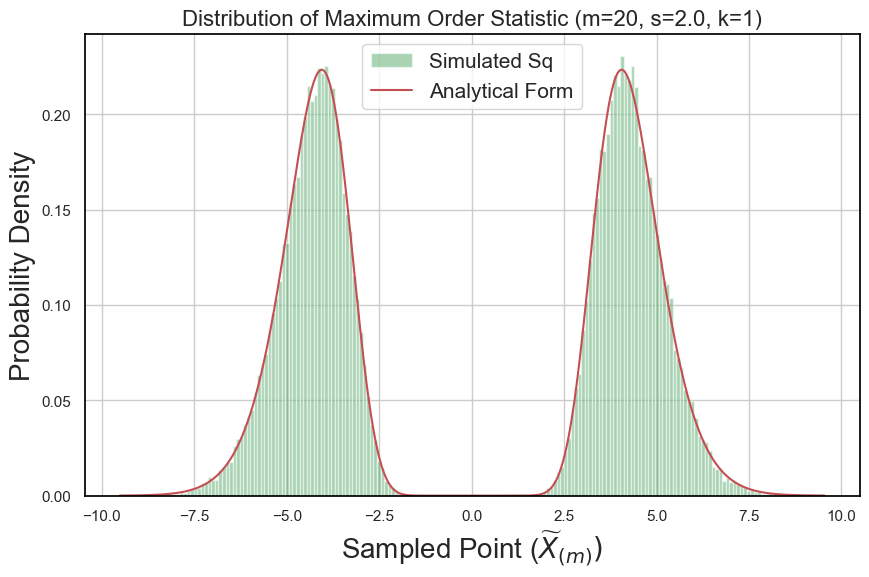

In [6]:
key = jax.random.PRNGKey(0)
# Parameters
m = 20  # Sample size
s = 2.0  # Standard deviation
size = 50000  # Number of samples to generate for comparison
k = 1

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Simulation
key = jax.random.PRNGKey(0)
samples = simulate_minmax_order_statistic(
    m, s, key, k, batch_sz=size
)  # simulate_minmax_order_statistic(n, s, size, key)
simulated_mean = jnp.mean(samples)
simulated_variance = jnp.var(samples)

# Results
x = jnp.linspace(jnp.min(samples), jnp.max(samples), 1001)  # how plot when k > 1?
pdf_values = [order_statistic_pdf(jnp.array([xMax]), m, k, s) for xMax in x]

plt.hist(samples, bins=200, density=True, alpha=0.5, color="g", label="Simulated Sq")
# plt.hist(simulate_minmax_order_statistic(m, s, key, k, batch_sz=size, useSquare=False), bins=200, density=True, alpha=0.5, color='b', label='Simulated Abs')
plt.plot(x, pdf_values, "r", label=r"Analytical Form")
# plt.plot(x, [order_statistic_pdf(jnp.array([xMax]), m, k, s, usechi2=False) for xMax in x], 'b', label='AryaVersion')
plt.xlabel(r"Sampled Point ($\widetilde{X}_{(m)})$", size=20)
plt.ylabel("Probability Density", size=20)
plt.title(
    "Distribution of Maximum Order Statistic (m=%i, s=%0.1f, k=%i)" % (m, s, k), size=16
)
plt.legend(prop={"size": 15})
plt.grid(True)
ax.spines["top"].set_color("black")
ax.spines["right"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.savefig("../plots/derived_k1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
pool_sizes = jnp.array(
    [
        2,
        5,
        10,
        20,
        30,
        40,
        50,
        60,
        80,
        100,
        150,
        200,
        300,
        400,
        500,
        600,
        800,
        1000,
        1500,
        2000,
        3000,
        4000,
        5000,
        7000,
        10000,
        15000,
        20000,
        30000,
        40000,
    ]
)

In [ ]:
def calculate_diff_m(k, s1=1.0, size1=3000, s2=2.0, size2=500):
    samples1 = jnp.array(
        [
            simulate_minmax_order_statistic(pool_sizes[i], s1, key, k, size1)
            for i in range(pool_sizes.shape[0])
        ]
    )
    simulated_variance = jnp.var(samples, axis=1)
    samples2 = jnp.array(
        [
            simulate_minmax_order_statistic(pool_sizes[i], s2, key, k, size2)
            for i in range(pool_sizes.shape[0])
        ]
    )
    simulated_variance2 = jnp.var(samples2, axis=1)
    return simulated_variance, simulated_variance2

In [11]:
# Parameters
def plot_gain_diffm(simulated_variance, simulated_variance2):
    x = jnp.log(pool_sizes[15:]).reshape(-1, 1)
    y = simulated_variance[15:]

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x)
    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y)

    # Predict using the trained model
    x_test = jnp.linspace(jnp.log(1.0), 13.0, 101).reshape(-1, 1)  # New input value
    x_test_poly = poly_features.transform(x_test)
    y_pred = model.predict(x_test_poly)
    plt.plot(
        pool_sizes,
        simulated_variance,
        lw=3,
        color="steelblue",
        label="3000 draws per simulation",
    )
    plt.plot(
        pool_sizes2,
        simulated_variance2 / 4,
        lw=2,
        linestyle="--",
        color="indianred",
        label="500 draws per simulation",
    )
    plt.plot(
        jnp.exp(x_test), y_pred, color="orange", label="Fit (second order polynomial)"
    )

    plt.axhline(y=1, color="black", linestyle="--")

    plt.xscale("log")
    plt.ylim([0, 25])
    plt.xlim([1, 5e4])

    plt.ylabel("Gain Factor, g(m)", size=22)
    plt.xlabel("Pool Size, m", size=22)
    plt.grid()

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle="round", facecolor="lightyellow", alpha=0.7)
    textstr = "g(m) = %0.2f + %0.2f $\ln(m)$ + %0.2f $\ln(m)^2$" % (
        model.intercept_,
        model.coef_[0][1],
        model.coef_[0][2],
    )
    # place a text box in upper left in axes coords
    plt.text(15, 3.5, textstr, fontsize=13.5, verticalalignment="top", bbox=props)

    plt.legend(loc=2, prop={"size": 14})
    plt.xticks(size=15)
    plt.yticks(size=15)

    x = jnp.log(pool_sizes2[20:]).reshape(-1, 1)
    y = simulated_variance2[20:] / 4.0
    poly_features = PolynomialFeatures(degree=2)
    x_poly = poly_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)

    plt.savefig("gain_factor_linear_regression_k1.pdf", bbox_inches="tight")

In [16]:
# Parameters
budgets = jnp.array(
    [1, 2, 5, 10, 50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000]
)
simulated_vars_k = jnp.array(
    [
        jnp.linalg.norm(
            jnp.var(
                simulate_minmax_order_statistic(
                    10000, s=1.0, key=key, k=budgets[i], batch_sz=1000
                ),
                axis=0,
            )
        )
        for i in range(len(budgets))
    ]
)
simulated_vars_k

m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000
m :  10000


In [78]:
def plot_gain_diffk(simulated_vars_k):
    x = jnp.log(budgets).reshape(-1, 1)
    y = simulated_vars_k

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=3)
    x_poly = poly_features.fit_transform(x)
    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y)

    # Predict using the trained model
    x_test = jnp.linspace(jnp.log(1.0), 13.0, 101).reshape(-1, 1)  # New input value
    x_test_poly = poly_features.transform(x_test)
    y_pred = model.predict(x_test_poly)
    plt.plot(
        budgets,
        simulated_vars_k,
        lw=3,
        color="steelblue",
        label="1000 draws per simulation",
    )
    plt.plot(
        jnp.exp(x_test), y_pred, color="orange", label="Fit (third order polynomial)"
    )

    plt.axhline(y=1, color="black", linestyle="--")

    plt.xscale("log")
    # plt.ylim([0, 25])
    plt.xlim([1, 1e4])

    plt.ylabel("Gain Factor, g(m=10000, k)", size=22)
    plt.xlabel("Budget Size, k", size=22)

    # these are matplotlib.patch.Patch properties
    props = dict(
        boxstyle="round", facecolor="lightyellow", alpha=0.7, edgecolor="black"
    )
    print(model.coef_)
    textstr = "g(m) = %0.2f + %0.2f $\ln(k)$ + %0.2f $\ln(k)^2$ + %0.2f $\ln(k)^3$" % (
        model.intercept_,
        model.coef_[1],
        model.coef_[2],
        model.coef_[3],
    )
    # place a text box in upper left in axes coords
    # plt.text(10, 4.5, textstr, fontsize=13.5, verticalalignment='top', bbox=props)
    ax = plt.gca()
    ax.text(
        0.05,
        0.15,
        textstr,
        fontsize=13.5,
        verticalalignment="top",
        bbox=props,
        transform=ax.transAxes,
    )

    plt.legend(loc=2, prop={"size": 14})
    plt.xticks(size=15)
    plt.yticks(size=15)

    # Add gridlines
    ax = plt.gca()  # Get current Axes
    custom_x_vals = [10, 100, 1000, 1e4]
    ax.set_xticks(custom_x_vals)

    # Turn off all automatic gridlines
    ax.grid(False)

    # Re-enable only y-axis gridlines
    ax.yaxis.grid(
        True, which="major", linestyle="-", linewidth=0.8, color="gray", alpha=0.8
    )

    # Manually add vertical gridlines at desired x-values
    for x in custom_x_vals:
        ax.axvline(x=x, color="gray", linestyle="-", linewidth=0.8, alpha=0.8)

    # Add black border around the plot

    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)

    plt.savefig("../plots/gain_factor_linear_regression_m10k.pdf", bbox_inches="tight")

[ 0.         -4.250542    6.222178   -0.42610326]


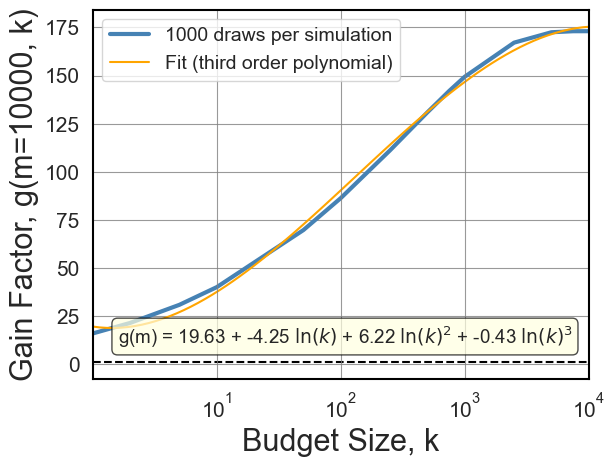

In [79]:
plot_gain_diffk(simulated_vars_k)